## CS-E4820 Machine Learning: Advanced Probabilistic Methods (spring 2022)

Pekka Marttinen, Prayag Tiwari, Vishnu Raj, Tianyu Cui, Yogesh Kumar, Antti Pöllänen, Louis Filstroff, Alex Aushev, Zheyang Shen, Nikitin Alexander , Sebastiaan De Peuter.

## Exercise 7, due on Tuesday March 22 at 23:50.

### Contents
1. Problem 1: ELBO for simple model (1/2)
2. Problem 2: ELBO for simple model (2/2)
3. Problem 3: Bayes factors
4. Problem 4: Model selection for GMM with BIC and cross-validation

# Problem 1: ELBO for the simple model (1/2)
This problem and the next deal with deriving the ELBO for the ‘simple model’, described in the PDF document 'simple_elbo.pdf'. Before doing these exercises, familiarize yourself with the contents of the document.

**(a)** Show that the general formula for ELBO, shown in Equation (8), can be written as the sum shown in Equation (9) for the simple model.

**(b)** Derive the 2nd term $E_{q(\theta)}[log p(\theta)]$ of the ELBO. (**Hint:** recall that $Var(X)=E(X^2)-E(X)^2$).

**(c)** Find out the formula for the 7th term $E_{q(\theta)[log q(\theta)]}$ of the ELBO. (**Hint:** see the 6th term)



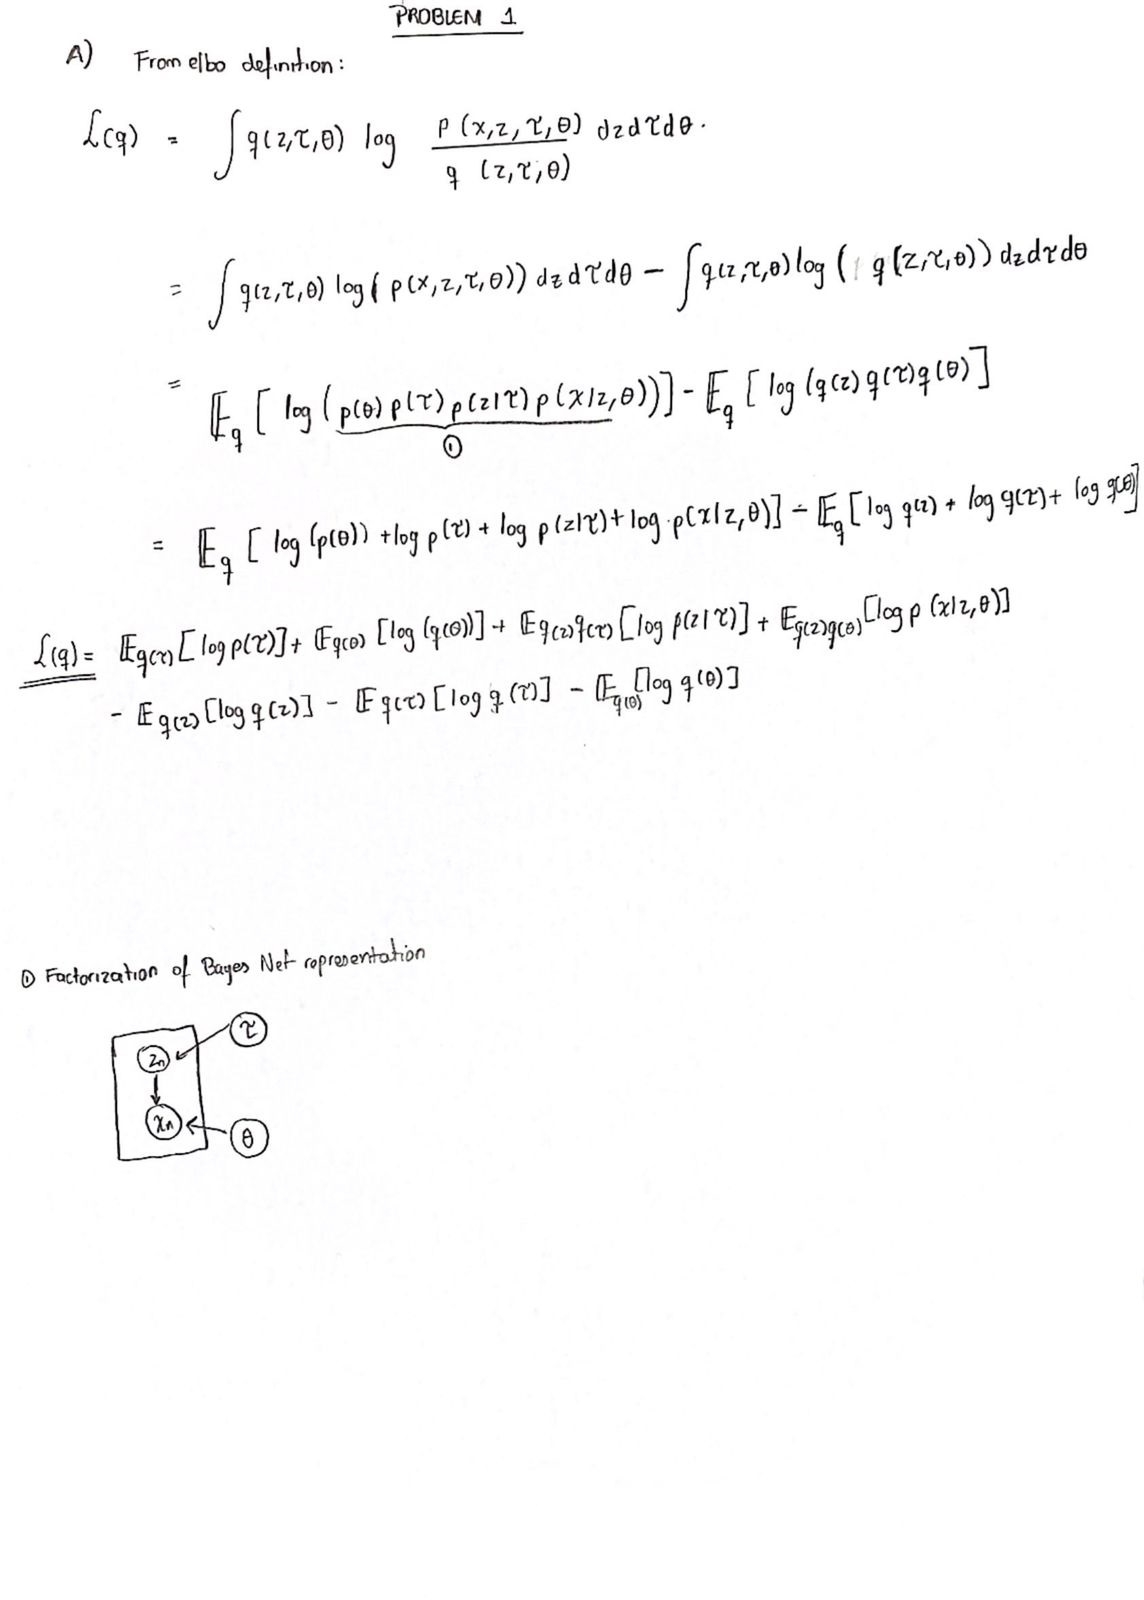

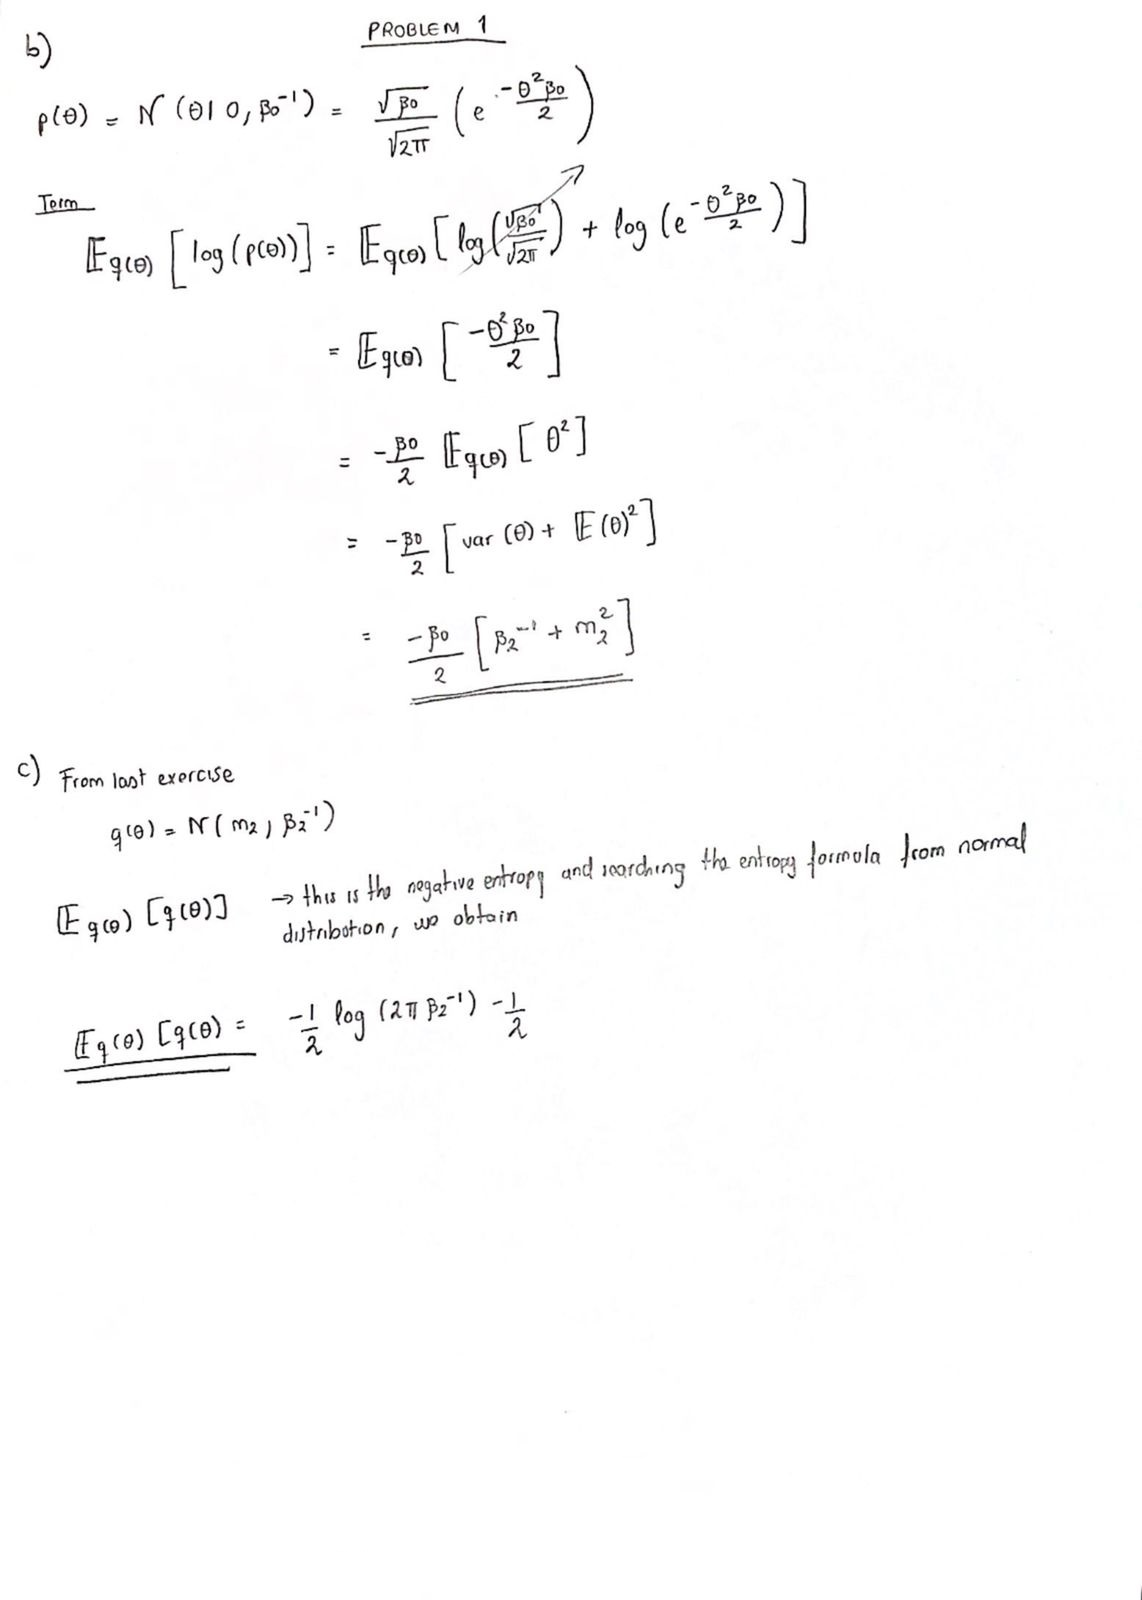

# Problem 2: ELBO for the simple model (2/2)

**(a)** Derive the 4th term $ E_{q(z)q(\theta)}\left[\log p(x \mid z, \theta)\right]$ of the ELBO. 

**Hint 1**: $E(XY) = E(X)E(Y)$ if X and Y are assumed indendent (see how this is already used in the derivation of term 3). 

**Hint 2**: $E(X-Y) = E(X - a + a - Y)^2$.

**(b)** Implement terms 2, 4, and 7 in the code template given below. Verify that the ELBO increases when you run the VB algorithm.

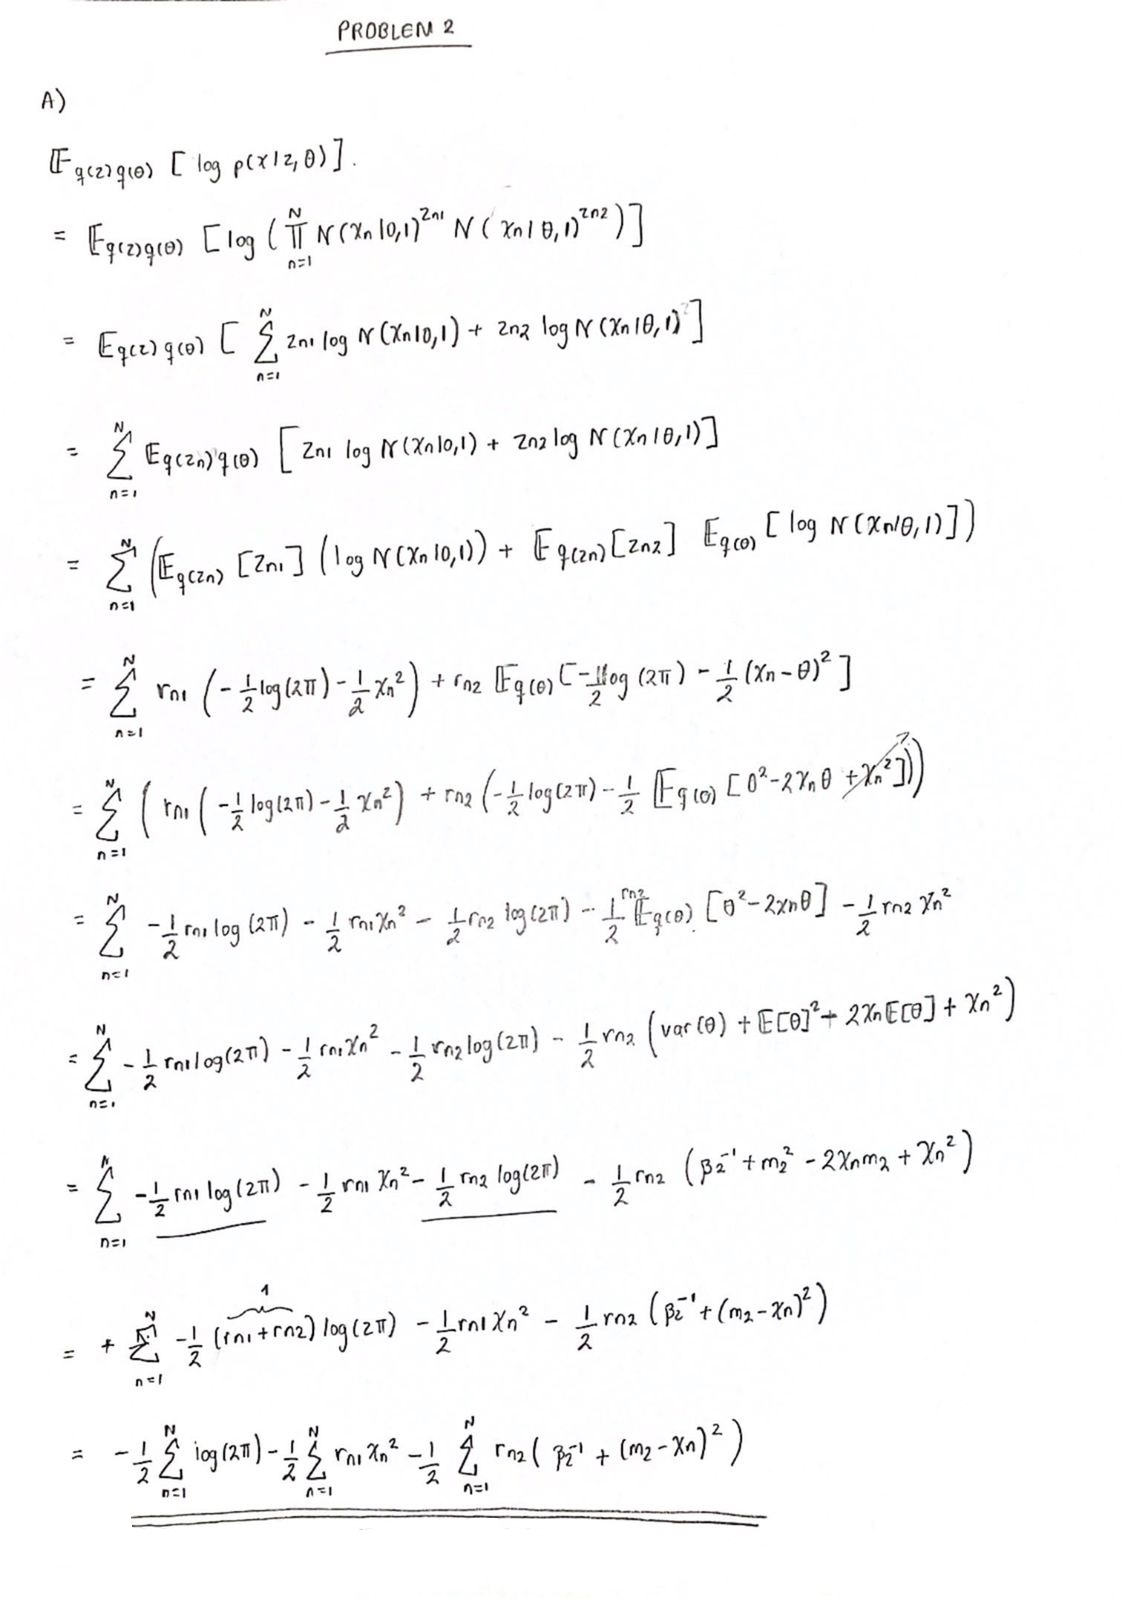 

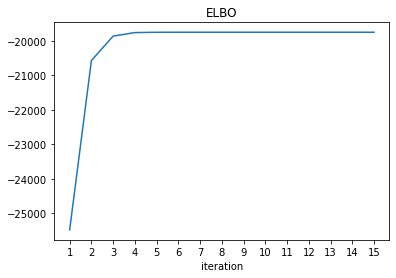

In [1]:
# Template for problem 2(b). 
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123123123)

# Compute ELBO for the model described in simple_elbo.pdf
def compute_elbo(alpha_tau, beta_tau, r1, r2, m2, beta2, alpha0, beta0, x):
    
    from scipy.special import psi, gammaln # digamma function, logarithm of gamma function
    
    # E[log p(tau)]
    term1 = (alpha0 - 1) * (psi(alpha_tau) + psi(beta_tau) - 2 * psi(alpha_tau + beta_tau))

    # E[log p(theta)]
    term2 = -(beta0/2) *((1/beta2)+(m2**2))
    
    # YOUR CODE HERE
    

    # E[log p(z|tau)]
    N2 = np.sum(r2); N1 = np.sum(r1); N = N1 + N2
    term3 = N2 * psi(alpha_tau) + N1 * psi(beta_tau) - N * psi(alpha_tau + beta_tau)

    # E[log p(x|z,theta)]

        
    term4 = (-(N/2)*np.log(2*np.pi)) - (1/2)*np.sum(r1*(x**2)) -(1/2)*np.sum(r2*(((x-m2)**2)+(1/beta2)))
    
    # YOUR CODE HERE
    

    # Negative entropy of q(z)
    term5 = np.sum(r1 * np.log(r1)) + np.sum(r2 * np.log(r2))

    # Negative entropy of q(tau)
    term6 = (gammaln(alpha_tau + beta_tau) - gammaln(alpha_tau) - gammaln(beta_tau)
        + (alpha_tau - 1) * psi(alpha_tau) + (beta_tau - 1) * psi(beta_tau)
        - (alpha_tau + beta_tau - 2) * psi(alpha_tau + beta_tau))

    # Negative entropy of q(theta)
    term7 = (-1/2)*np.log(2*np.pi*(1/beta2))-(1/2)
    
    # YOUR CODE HERE
   

    elbo = term1 + term2 + term3 + term4 - term5 - term6 - term7
    
    return elbo


# Simulate data
theta_true = 4
tau_true = 0.3
n_samples = 10000
z = (np.random.rand(n_samples) < tau_true)  # True with probability tau_true
x = np.random.randn(n_samples) + z * theta_true

# Parameters of the prior distributions.
alpha0 = 0.5
beta0 = 0.2

n_iter = 15 # The number of iterations
elbo_array = np.zeros(n_iter) # To track the elbo

# Some initial value for the things that will be updated
E_log_tau = -0.7   # E(log(tau))
E_log_tau_c = -0.7  # E(log(1-tau))
E_log_var = 4 * np.ones(n_samples)  # E((x_n-theta)^2)
r2 = 0.5 * np.ones(n_samples)  # Responsibilities of the second cluster.

for i in range(n_iter):
    
    # Updated of responsibilites, factor q(z)
    log_rho1 = E_log_tau_c - 0.5 * np.log(2 * np.pi) - 0.5 * (x ** 2)
    log_rho2 = E_log_tau - 0.5 * np.log(2 * np.pi) - 0.5 * E_log_var
    max_log_rho = np.maximum(log_rho1, log_rho2)  # Normalize to avoid numerical problems when exponentiating.
    rho1 = np.exp(log_rho1 - max_log_rho)
    rho2 = np.exp(log_rho2 - max_log_rho)
    r2 = rho2 / (rho1 + rho2)
    r1 = 1 - r2
    
    N1 = np.sum(r1)
    N2 = np.sum(r2)
    
    # Update of factor q(tau)
    from scipy.special import psi # digamma function
    E_log_tau = psi(N2 + alpha0) - psi(N1 + N2 + 2*alpha0)
    E_log_tau_c = psi(N1 + alpha0) - psi(N1 + N2 + 2*alpha0)
    
    # Update of factor q(theta)
    x2_avg = 1 / N2 * np.sum(r2 * x)
    beta_2 = beta0 + N2
    m2 = 1 / beta_2 * N2 * x2_avg
    E_log_var = (x - m2) ** 2 + 1 / beta_2
    
    # Keep track of the current estimates
    tau_est = (N2 + alpha0) / (N1 + N2 + 2*alpha0)
    theta_est = m2
    
    # Compute ELBO
    alpha_tau = N2 + alpha0
    beta_tau = N1 + alpha0
    elbo_array[i] = compute_elbo(alpha_tau, beta_tau, r1, r2, m2, beta_2, alpha0, beta0, x)

# Plot ELBO as a function of iteration
plt.plot(np.arange(n_iter) + 1, elbo_array)
plt.xticks(np.arange(n_iter) + 1)
plt.xlabel("iteration")
plt.title("ELBO")
plt.show()

# Problem 3: Bayes factors
Suppose we have two bags, each containing a large number of black and white marbles. To learn about the contents of the bags, we have done 5 draws from each bag. After each draw, the marble drawn has been returned to the bag. The draws from the first bag are as follows ( B, W, W, B, B ) and the draws from the second bag are ( B, B, B, B, W ) , where B corresponds to a Black marble and W to a White marble. 

Consider two models:

- $M_1$ : the proportions of marbles are the same in the two bags

- $M_2$ : the proportions of marbles are different in the two bags.

**(a)** Write out the two models explicitly. Assuming that a priori all proportions are equally probable, compute the Bayes factor in favor of $M_1$.

**(b)** The same as (a), but now the first set of draws contains 300 black and 200 white draws,
and second set of draws 250 black and 250 white draws.

**Hint**: Beta distribution is the conjugate prior for the Binomial/Bernoulli likelihood, and a uniform proportion corresponds to the $Beta( 1, 1)$ distribution.





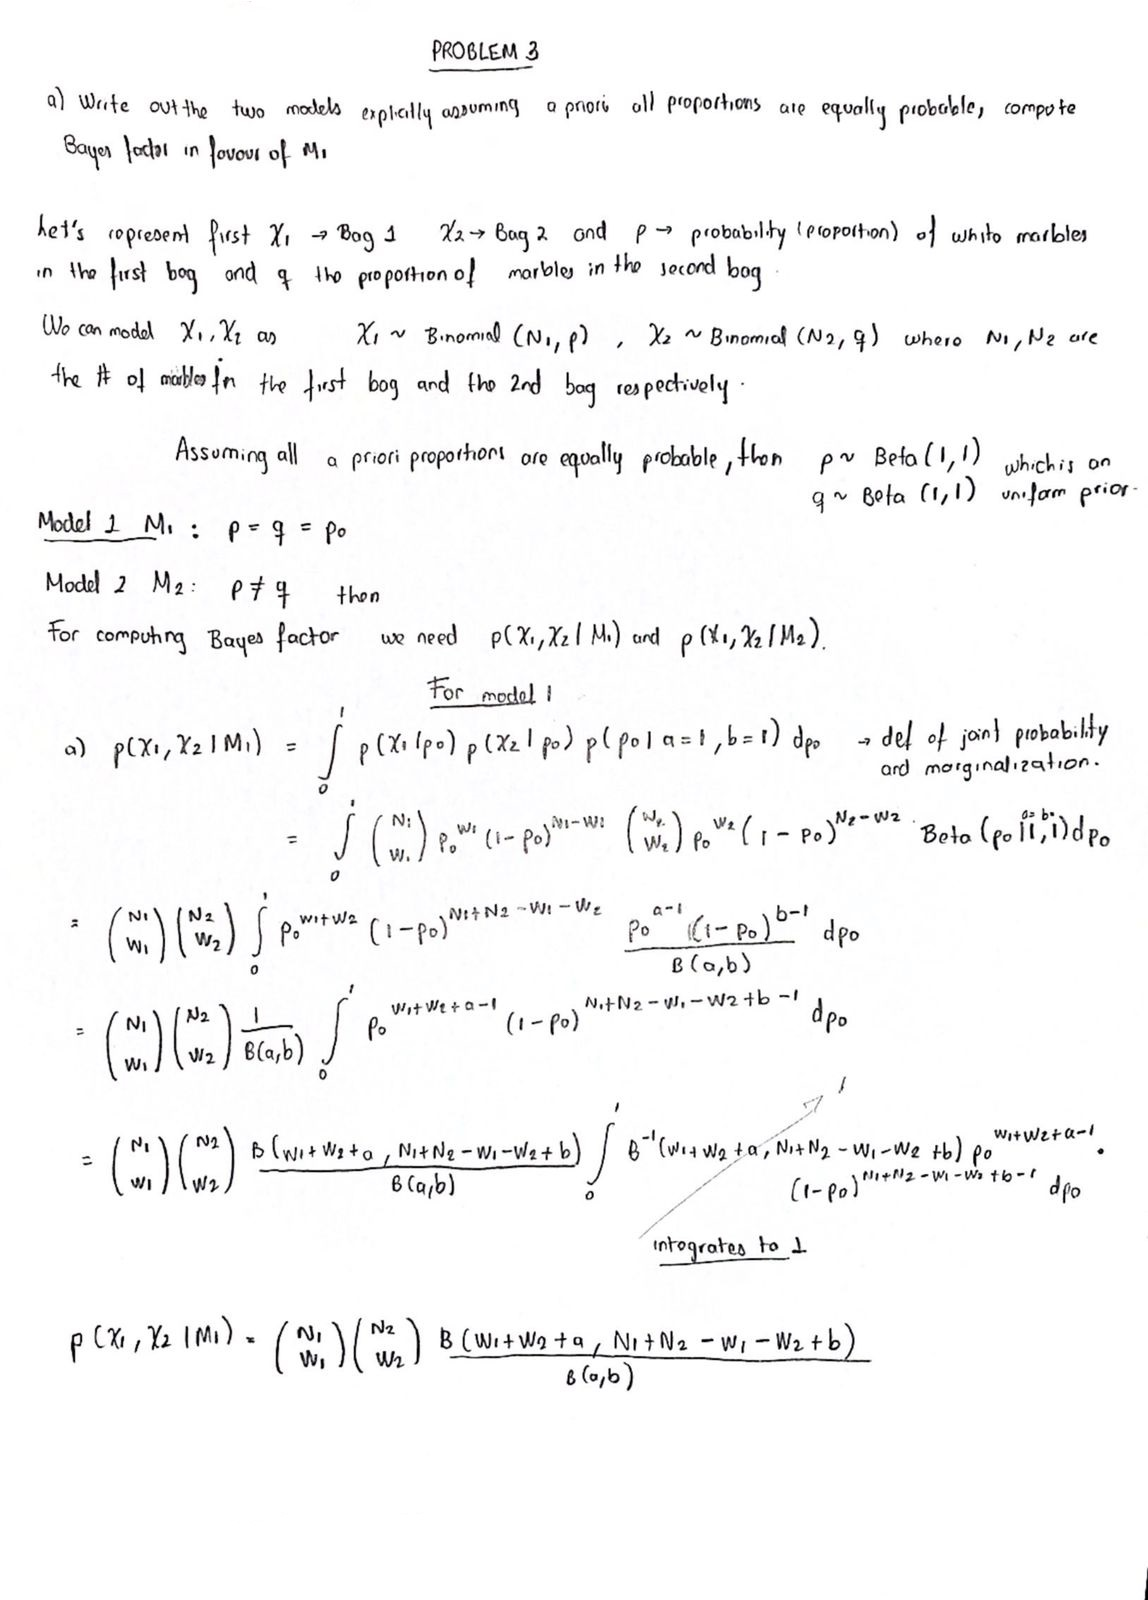

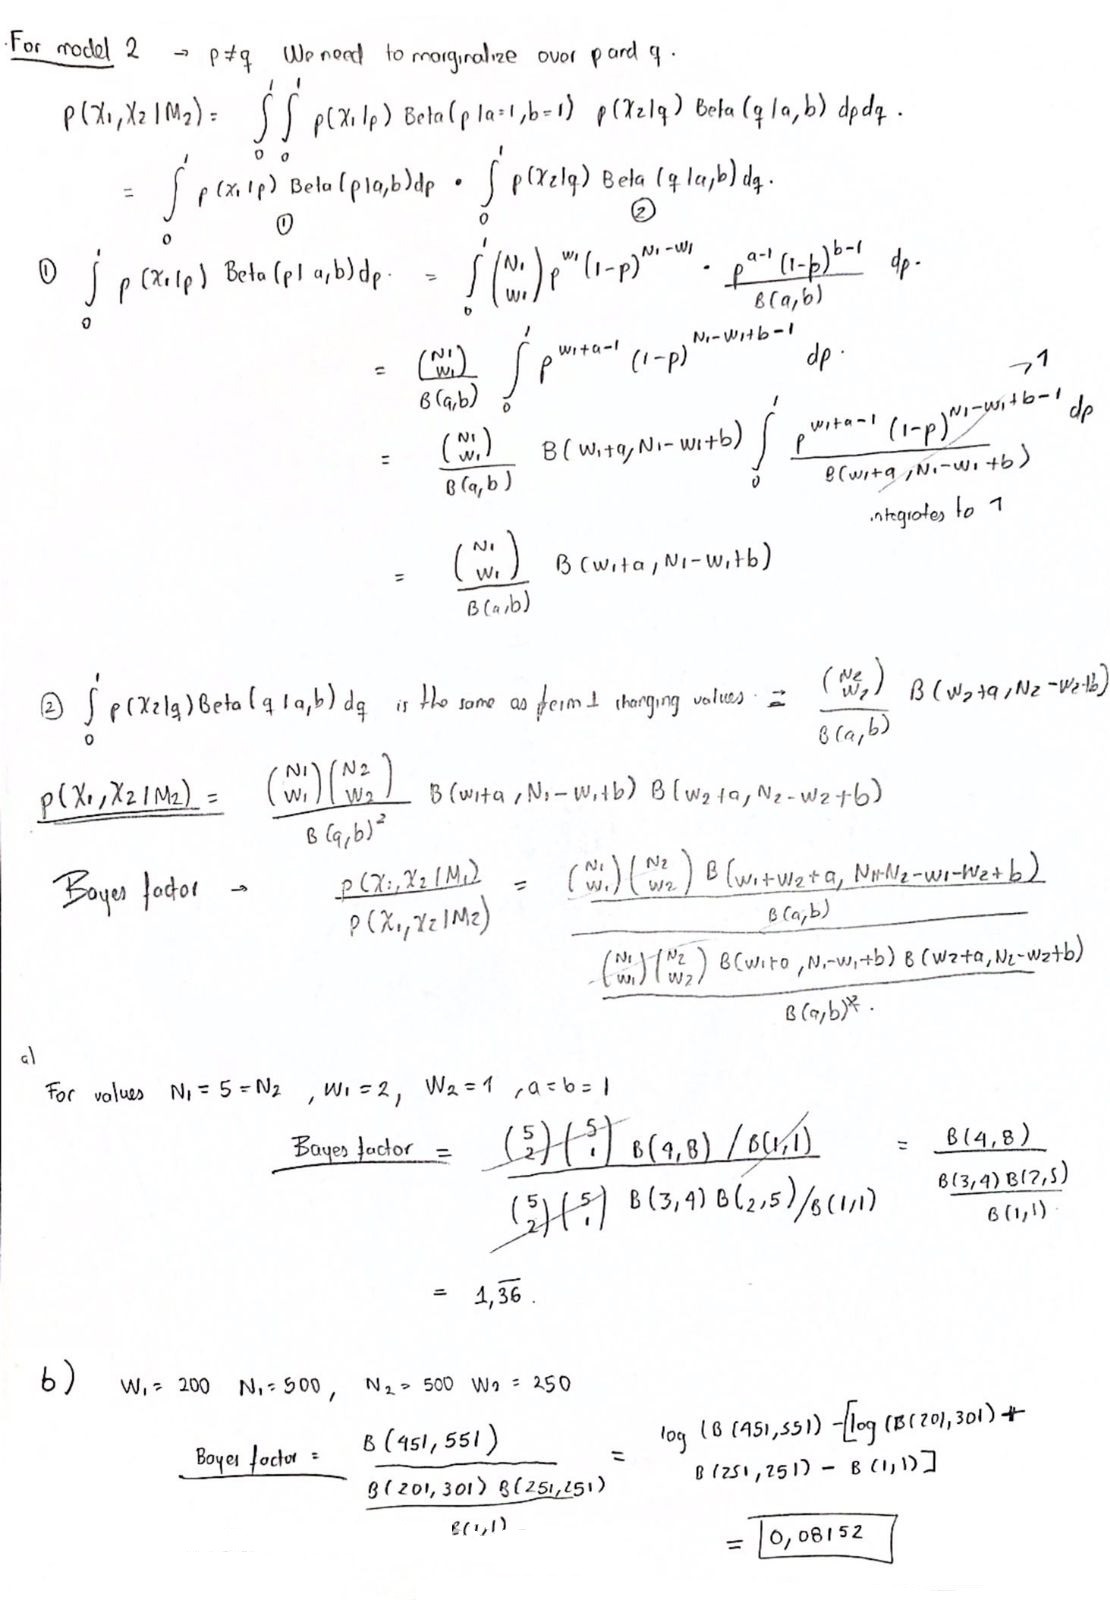

# Problem 4: Model selection for GMM with BIC and cross validation

In many machine learning applications model selection is crucial. In this exercise, you
will practice two common approaches for model selection: 

- Bayesian Information Criterion (BIC) (as an approximation to ‘Bayesian model selection’) and  

- Cross-Validation (as a representative for a predictive model selection criterion).

You are given a data set (1000 samples of dimension 2) contained in the file data.pickle, which has been sampled from a Gaussian Mixture Model (GMM) using three classes(the true class labels are given for your convenience, but they should not be used in learning the model).

In the given code template below, the data will be divided into training and test sets.

**(a)** Complete the functions 'compute_bic' and 'cross_validate'. Use both criteria to select the number of components in the GMM using the training data. Plot the both the BIC and the validation log-likelihoods as a function of the number of components, as well as the data with the best model. Do both methods find a model with three components as the most likely?

**(b)** Use the selected models to evaluate the test set log-likelihood.

**(c)** Explain briefly the pros and cons of the two approaches and comment which approach you would consider better and why.

**Hint**: What is the total number of parameters needed to specify the component
means and covariance matrices, and the mixture weights? You will need this
number to compute BIC.

In [2]:
# This Starter code for problem 4. The solution template is in the cell below.
# Tools for learning Gaussian mixture models; adapted from the BRMLtoolkit by David Barber.
import numpy as np
import numpy.matlib as matlib
import numpy.linalg as LA
#import scipy.misc
from scipy.special import logsumexp

def condp(X):
    return X / np.sum(X, axis=0)

def condexp(logp):
    pmax = np.max(logp, axis=0)
    P = logp.shape[0]
    return condp(np.exp(logp - np.tile(pmax, (P, 1))))

def GMMlogp(X, H, P, m, S):
    D, N = X.shape  # dimension and number of points

    logp = np.zeros((N, H))
    for i in range(H):
        invSi = LA.inv(S[i,:,:])
        sign, logdetSi = LA.slogdet(2 * np.pi * S[i,:,:])

        for n in range(N):
            v = X[:,n] - m[:,i]
            logp[n,i] = -0.5 * (v @ invSi @ v) - 0.5 * logdetSi + np.log(P[i])

    return logp



# Log Likelihood of data X under a Gaussian Mixture Model
#
# X : each column of X is a datapoint.
# P : mixture coefficients
# m : means
# S : covariances
#
# Returns: A list containing the log likelihood for each data point in X
def GMMloglik(X, P, m, S):
    N = X.shape[1]
    H = m.shape[1]

    logp = GMMlogp(X, H, P, m, S)
    logl = [logsumexp(a=logp[n,:], b=np.ones(H)) for n in range(N)]

    return logl

# Fit a mixture of Gaussian to the data X using EM
#
# X : each column of X is a datapoint.
# H : number of components of the mixture.
# n_iter : number of EM iterations
#
# Returns: (P, m, S, loglik, phgn)
# P : learned mixture coefficients
# m : learned means
# S : learned covariances
# loglik : log likelihood of the learned model
# phgn : mixture assignment probabilities
def GMMem(X, H, n_iter):
    D, N = X.shape  # dimension and number of points

    # initialise the centres to random datapoints
    r = np.random.permutation(N)
    m = X[:, r[:H]]

    # initialise the variances to be large
    s2 = np.mean(np.diag(np.cov(X)))
    S = matlib.tile(s2 * np.eye(D), [H, 1, 1])

    # intialise the component probilities to be uniform
    P = np.ones(H) / H

    for emloop in range(n_iter):
        # E-step:
        logpold = GMMlogp(X, H, P, m, S)

        phgn = condexp(logpold.T)  # responsibilities
        pngh = condp(phgn.T)       # membership

        # M-step:
        for i in range(H):   # now get the new parameters for each component
            tmp = (X - np.tile(m[:,i:i+1], N)) * np.tile(np.sqrt(pngh[:,i]), (D,1))
            Scand = np.dot(tmp, tmp.T)

            if LA.det(Scand) > 0.0001:   # don't accept too low determinant
                S[i,:,:] = Scand

        m = np.dot(X, pngh)
        P = np.sum(phgn, axis=1) / N

    logl = np.sum(logsumexp(a=logpold[n,:], b=np.ones(H)) for n in range(N))

    return P, m, S, logl, phgn

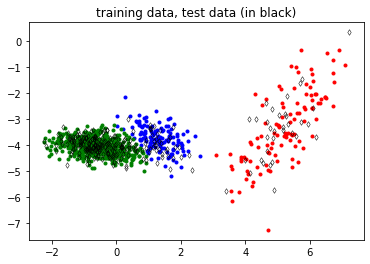

computing cross validation score
H: 1


<ipython-input-2-f8b655a5c890>:94: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  logl = np.sum(logsumexp(a=logpold[n,:], b=np.ones(H)) for n in range(N))


H: 2
H: 3
H: 4
H: 5


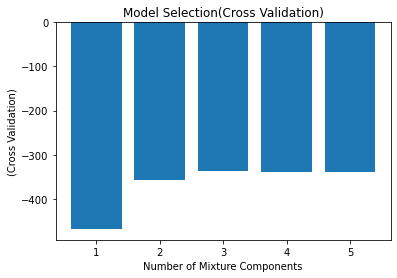

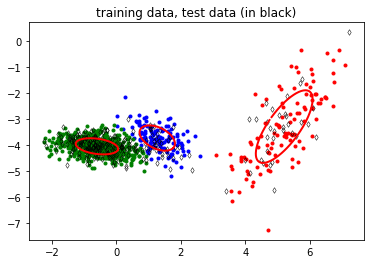

In [3]:
    # Template for problem 4
    import matplotlib.pyplot as plt
    import pickle

    np.random.seed(0)
    totalComponents = 5  # max number of mixture components
    criterion_flag = 0    # 0: cross validation, 1: BIC

    def compute_bic(Xtrain):
        BICs = []
        for H in range(1, totalComponents+1):    # number of mixture components
            print("H: {}".format(H))

            P, m, S, loglik, phgn = GMMem(Xtrain, H, 100)  # fit to data

            numParams = 6*H-1 # number of parameters in the model
            BIC = [loglik - ((numParams)/2) * np.log(Xtrain.shape[1])]            # BIC for the model

            

            BICs.append(BIC)
        return BICs

    def cross_validate(Xtrain):
        foldCount = 5    # number of folds

        loglik = np.zeros((totalComponents, foldCount))

        Nlearning = Xtrain.shape[1]
        order = np.random.permutation(Nlearning)    # to randomize the sample order

        for H in range(1, totalComponents+1):     # number of mixture components
            print("H: {}".format(H))

            for fold in range(foldCount):    # K-fold cross validation (K=5)
                ind = fold * int(Nlearning/foldCount) + np.arange(int(Nlearning/foldCount))
                val_indices = order[ind]

                training_indices = np.setdiff1d(np.arange(Nlearning), val_indices);

                X_train = Xtrain[:,training_indices]  # cv training data
                X_val   = Xtrain[:,val_indices]       # cv validation data

                # train model
                P1, m1, S1, loglik1, phgn1 = GMMem(X_train, H, 100)   # fit model

                # Predict using the cv trained model
                logl1 = GMMloglik(X_val, P1, m1, S1)
                loglik[H-1,fold] = np.sum(logl1)

                # YOUR CODE HERE
        return loglik


    # load data
    with open("/coursedata/data.pickle", "rb") as f:
        X, labels = pickle.load(f)

    D, N = X.shape   # dimension and number of data points

    ratio = 0.75
    train_ind = np.random.choice(N, int(ratio * N), replace=False)   # training data index
    test_ind = np.setdiff1d(np.arange(N), train_ind)                 # test data index

    Xtrain = X[:,train_ind]            # training data
    Xtrain_labels = labels[train_ind]  # training data labels

    Xtest = X[:,test_ind]            # test data
    Xtest_labels = labels[test_ind]  # test data labels

    # plot training and test data
    def plot_data():
        for i in sorted(set(Xtrain_labels)):
            X_comp = Xtrain[:, Xtrain_labels == i]
            plt.plot(X_comp[0], X_comp[1], '.' + 'brgmcyk'[i-1], markersize=6)

        plt.plot(Xtest[0], Xtest[1], 'kd', markersize=4, markeredgewidth=0.5, markerfacecolor="None")

    plot_data()
    plt.title('training data, test data (in black)')
    plt.show()



    # ***** Use BIC to select the number of components
    # (Only this part differs from the second template, where cross validation is used instead)

    if criterion_flag:
        print('computing BIC')
        scores = compute_bic(Xtrain)
        ylabel = "(BIC)"
    elif not criterion_flag:
        print('computing cross validation score')
        scores = cross_validate(Xtrain)
        ylabel = "(Cross Validation)"

    # plot the BIC curve
    plt.bar(np.arange(1, totalComponents+1), np.mean(scores, axis=1))
    #plt.yscale("log", nonposy="clip")
    plt.xlabel('Number of Mixture Components')
    plt.ylabel(ylabel)
    plt.title('Model Selection' + ylabel )
    plt.show()

    # select the number of mixture components which minimizes the BIC
    h = np.argmax(np.mean(scores, axis=1)) + 1



    # ***** TRAIN

    # Now train full model with selected number of mixture components
    P, m, S, loglik, phgn = GMMem(Xtrain, h, 100)  # fit to data

    # Predict using the full trained model (Use GMMem.GMMloglik)
    logl = GMMloglik(Xtest, P,m,S)
    # print('Test Data Likelihood = {0:f}'.format(?))

    # YOUR CODE HERE
    

    # Plot the best GMM model
    plot_data()

    for i in range(h):
        dV, E = LA.eig(S[i,:,:])

        theta = np.arange(0, 2*np.pi, 0.1)
        p = np.sqrt(dV.reshape(D,1)) * [np.cos(theta), np.sin(theta)]
        x = (E @ p) + np.tile(m[:,i:i+1], (1, len(theta)))

        plt.plot(x[0], x[1], 'r-', linewidth=2)

    plt.title('training data, test data (in black)')
    plt.show()